In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import lmfit

In [16]:
palette = [
    "#3C38A0",  # deep indigo
#    "#7152B8",  # royal purple (new)
    "#1B7A6E",  # lighter teal
    "#3A2C20",  # cool dark brown
    "#C26824",  # bright burnt orange
    "#7A014A",  # wine magenta
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette)

plt.rcParams["font.family"] = "Times New Roman"     # Normal text
plt.rcParams["mathtext.fontset"] = "custom"        # Custom math font
plt.rcParams["mathtext.rm"] = "Times New Roman"    # Roman font for math
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"
plt.rcParams["font.size"] = 14

In [3]:
def read_spe(date, infile):

    os.chdir(date) 
    
    hist_cts = []
    
    with open(infile) as f:
        for lineno, line in enumerate(f):
            if  12 <= lineno < 2060:
                hist_cts.append(float(line.strip()))
    hist_cts = np.array(hist_cts)
    
    os.chdir('..')

    return hist_cts 

def rebin(x, hist, factor):#### counts = hist
    new_x = x[::factor]
    new_hist = hist.reshape(-1, factor).sum(axis=1)
    return new_x, new_hist

def remove_zero_raw(x, hist):
    mask = np.where(hist>0)
    hist = hist[mask]
    x = x[mask]
    return x, hist
    

def run_time_cal(bin_cal, time_cal):
    # --- USER INPUT -------------------------------------------------------------
    # Replace these with your actual calibration data
    
    num_bins = 2048   # total number of bins in your histogram
    # ---------------------------------------------------------------------------
    
    # --- FIT LINEAR RELATION ----------------------------------------------------
    # Fit t = a * bin + b
    coeffs = np.polyfit(bin_cal, time_cal, 1)
    a, b = coeffs
    print(f"Linear calibration fit: time = {a:.6e} * bin + {b:.6e}")
    
    # --- GENERATE TIMESTAMPS ----------------------------------------------------
    bins = np.arange(num_bins)
    timestamps = a * bins + b
    
    # --- CHECK TOTAL RANGE ------------------------------------------------------
    print(f"Time range: {timestamps[0]:.3f} to {timestamps[-1]:.3f} (units same as input)")
    
    return timestamps

    
def run_binned_fit(bin_centers, hist_ct, hist_err, model, guess):
    
    model = lmfit.Model(model)
    
    # Zip names and values into a dict
    guess_dict = dict(zip(model.param_names, guess))

    result = model.fit(hist_ct, x=bin_centers, weights=1/np.sqrt(hist_ct), **guess_dict)
    
    lmfit.report_fit(result)

    return bin_centers, hist_ct, result
    

#### some plotting stuff
def plot_binned_fit(bin_centers, hist_ct, fit_result, xlabel, ylabel, model):

    x_fit = np.linspace(bin_centers[0],bin_centers[-1])
    y_fit = fit_result.eval(x=x_fit)
    
    y_pred = fit_result.eval(x=bin_centers)
    y_err = np.sqrt(hist_ct)
    pull = (hist_ct - y_pred)/y_err
    
    # --- Create figure with 2 panels ---
    fig, (ax_main, ax_pull) = plt.subplots(
        2, 1, sharex=True,
        gridspec_kw={'height_ratios': [6, 1]},
        figsize=(6, 5)
    )
    
    # --- Top: data + fit ---
    ax_main.errorbar(bin_centers, hist_ct, y_err, fmt='k+', label='data')
    ax_main.plot(x_fit, y_fit, color="#BF0000", label= model +' '+'fit')
    ax_main.set_ylabel("counts")
    ax_main.legend(frameon = False)
    ax_main.annotate(r"model: $y = s\cdot\exp(- \frac{(x-\mu)^2}{2 \sigma_1^2}) + b$", xy = (0,1))
    # --- Bottom: pulls ---
    ax_pull.scatter(bin_centers, pull, color='black', marker="+", s=50)
    ax_pull.axhline(0, color='black', linestyle='-')
    ax_pull.axhline(3, color="#BF0000", linestyle='--')
    ax_pull.axhline(-3, color="#BF0000", linestyle='--')
    ax_pull.set_xlabel(xlabel)
    ax_pull.set_ylabel(r"pulls ($\sigma$)")
    ax_pull.set_ylim(-5,5)
    
    plt.tight_layout()
    plt.show()
    return fig, (ax_main, ax_pull)

In [4]:
bin_cal = np.array([328, 720, 1114, 1508, 1902])      # known bin indices
time_cal = np.array([10, 20, 30, 40, 50])   # corresponding times (e.g. ns)
time_0929 = run_time_cal(bin_cal, time_cal)

Linear calibration fit: time = 2.540648e-02 * bin + 1.687021e+00
Time range: 1.687 to 53.694 (units same as input)


In [5]:
bin_cal = np.array([347, 741, 1137, 1532, 1928])      # known bin indices
time_cal = np.array([10, 20, 30, 40, 50])   # corresponding times (e.g. ns)   
time_1006 = run_time_cal(bin_cal, time_cal)

Linear calibration fit: time = 2.529722e-02 * bin + 1.237055e+00
Time range: 1.237 to 53.020 (units same as input)


In [6]:
bin_cal = np.array([336, 729, 1125, 1520, 1915])      # known bin indices
time_cal = np.array([10, 20, 30, 40, 50])   # corresponding times (e.g. ns)
time_1008 = run_time_cal(bin_cal, time_cal)

Linear calibration fit: time = 2.532284e-02 * bin + 1.511810e+00
Time range: 1.512 to 53.348 (units same as input)


In [7]:
print(np.mean(time_1008-time_1006))
print(np.mean(time_1006-time_0929))

print(np.sqrt(0.300**2+0.562**2)/2)

0.30096719083624934
-0.5617861796214003
0.31852943349084717


10128.0
22.24957131769299
10989.0
22.418859809700322
7258.0
23.230594153920386
6863.0
23.18105054770554
5660.0
23.983227735399332
4123.0
25.95380639074999
54822.0
26.67354737388494
43570.0
27.817782984247103
60840.0
28.8494368691598


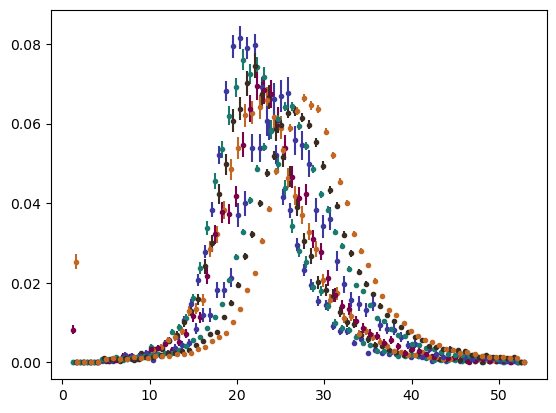

In [8]:
hist = read_spe('2025-10-01', '1001-speed-10ft-51.0.Spe')
time, hist = rebin(time_0929, hist,32)
print(np.sum(hist[1:]))
#time, hist = remove_zero(time, hist )
plt.errorbar( time, hist/np.sum(hist), yerr = np.sqrt(hist)/np.sum(hist), fmt = '.')
mean = np.average(time, weights=hist)
print(mean)

hist = read_spe('2025-10-06', '1006-speed-10ft-74.8.Spe')
time, hist = rebin(time_1006, hist,32)
print(np.sum(hist[1:]))
plt.errorbar( time, hist/np.sum(hist), yerr = np.sqrt(hist)/np.sum(hist), fmt = '.')
mean = np.average(time, weights=hist)
print(mean)

hist = read_spe('2025-10-01', '1001-speed-10ft-101.3.Spe')
time, hist = rebin(time_0929, hist, 32)
print(np.sum(hist[1:]))
plt.errorbar( time, hist/np.sum(hist), yerr = np.sqrt(hist)/np.sum(hist), fmt = '.')
mean = np.average(time, weights=hist)
print(mean)

hist = read_spe('2025-10-08', '1008-speed-10ft-125.0.Spe')
time, hist = rebin(time_1008, hist, 32)
print(np.sum(hist[1:]))
plt.errorbar( time, hist/np.sum(hist), yerr = np.sqrt(hist)/np.sum(hist), fmt = '.')
mean = np.average(time, weights=hist)
print(mean)

hist = read_spe('2025-10-06', '1006-speed-10ft-150.5.Spe')
time, hist = rebin(time_1006, hist, 32)
print(np.sum(hist[1:]))
plt.errorbar( time, hist/np.sum(hist), yerr = np.sqrt(hist)/np.sum(hist), fmt = '.')
mean = np.average(time, weights=hist)
print(mean)

hist = read_spe('2025-10-08', '1008-speed-10ft-201.0.Spe')
time, hist = rebin(time_1008, hist, 32)
print(np.sum(hist[1:]))
plt.errorbar( time, hist/np.sum(hist), yerr = np.sqrt(hist)/np.sum(hist), fmt = '.')
mean = np.average(time, weights=hist)
print(mean)

hist = read_spe('2025-10-07', '1007-speed-10ft-230.2.Spe')
time, hist = rebin(time_1006, hist, 32)
print(np.sum(hist[1:]))
plt.errorbar( time, hist/np.sum(hist), yerr = np.sqrt(hist)/np.sum(hist), fmt = '.')
mean = np.average(time, weights=hist)
print(mean)

hist = read_spe('2025-10-08', '1008-speed-10ft-255.0.Spe')
time, hist = rebin(time_1008, hist, 32)
print(np.sum(hist[1:]))
plt.errorbar( time, hist/np.sum(hist), yerr = np.sqrt(hist)/np.sum(hist), fmt = '.')
mean = np.average(time, weights=hist)
print(mean)

hist = read_spe('2025-10-01', '1001-speed-10ft-286.2.Spe')
time, hist = rebin(time_0929, hist, 32)
print(np.sum(hist[1:]))
plt.errorbar( time, hist/np.sum(hist), yerr = np.sqrt(hist)/np.sum(hist), fmt = '.')
mean = np.average(time, weights=hist)
print(mean)


In [107]:
hist = read_spe('2025-10-01', '1001-speed-10ft-51.0.Spe')
time0510, hist0510 = remove_zero_raw(*rebin(time_0929, hist, 32))
N0510 = np.sum(hist0510[1:])
normed0510 = hist0510[1:] / N0510

hist = read_spe('2025-10-06', '1006-speed-10ft-74.8.Spe')
time0748, hist0748 = remove_zero_raw(*rebin(time_1006, hist, 32))
N0748 = np.sum(hist0748[1:])
normed0748 = hist0748[1:] / N0748

hist = read_spe('2025-10-01', '1001-speed-10ft-101.3.Spe')
time1013, hist1013 = remove_zero_raw(*rebin(time_0929, hist, 32))
N1013 = np.sum(hist1013[1:])
normed1013 = hist1013[1:] / N1013

hist = read_spe('2025-10-08', '1008-speed-10ft-125.0.Spe')
time1250, hist1250 = remove_zero_raw(*rebin(time_1008, hist, 32))
N1250 = np.sum(hist1250[1:])
normed1250 = hist1250[1:] / N1250

hist = read_spe('2025-10-06', '1006-speed-10ft-150.5.Spe')
time1505, hist1505 = remove_zero_raw(*rebin(time_1006, hist, 32))
N1505 = np.sum(hist1505[1:])
normed1505 = hist1505[1:] / N1505

hist = read_spe('2025-10-08', '1008-speed-10ft-201.0.Spe')
time2010, hist2010 = remove_zero_raw(*rebin(time_1008, hist, 16))
N2010 = np.sum(hist2010[1:])
normed2010 = hist2010[1:] / N2010

hist = read_spe('2025-10-07', '1007-speed-10ft-230.2.Spe')
time2302, hist2302 = remove_zero_raw(*rebin(time_1006, hist, 32))
N2302 = np.sum(hist2302[1:])
normed2302 = hist2302[1:] / N2302

hist = read_spe('2025-10-08', '1008-speed-10ft-255.0.Spe')
time2550, hist2550 = remove_zero_raw(*rebin(time_1008, hist, 32))
N2550 = np.sum(hist2550[1:])
normed2550 = hist2550[1:] / N2550

hist = read_spe('2025-10-01', '1001-speed-10ft-286.2.Spe')
time2862, hist2862 = remove_zero_raw(*rebin(time_0929, hist, 32))
N2862 = np.sum(hist2862[1:])
normed2862 = hist2862[1:] / N2862

print(N0510, N0748, N1013, N1250, N1505, N2010, N2302, N2550, N2862)

10122.0 10984.0 7256.0 6863.0 5660.0 4122.0 54815.0 43568.0 60840.0


In [98]:
def gaussian(x, mu, sigma, s):
    return s*np.exp(-(x - mu)**2 / (2* sigma**2))/np.sqrt(2*np.pi*sigma**2) 


def gaussian_w_bkg(x, mu, sigma, s, lam, b):
    return s*np.exp(-(x - mu)**2 / (2* sigma**2))/np.sqrt(2*np.pi*sigma**2) + b*np.exp(-lam*x)

def split_gaussian_w_bkg(x, mu, sigma1, sigma2, s, b):
    sig = s*np.where(
                     x < mu, 
                     s*np.exp(-(x - mu)**2 / (2* sigma1**2)) , 
                     s*np.exp(-(x - mu)**2 / (2* sigma2**2))
                    ) 
    bkg = b
    return sig+bkg  


In [108]:
def plot_binned_fit(bin_centers, hist_ct, fit_result, xlabel, ylabel, model):

    x_fit = np.linspace(bin_centers[0],bin_centers[-1])
    y_fit = fit_result.eval(x=x_fit)
    
    y_pred = fit_result.eval(x=bin_centers)
    y_err = np.sqrt(hist_ct)
    pull = (hist_ct - y_pred)/y_err
    
    # --- Create figure with 2 panels ---
    fig, (ax_main, ax_pull) = plt.subplots(
        2, 1, sharex=True,
        gridspec_kw={'height_ratios': [6, 1]},
        figsize=(6.5, 4.5)
    )
    
    # --- Top: data + fit ---
    ax_main.errorbar(bin_centers, hist_ct, y_err, fmt='k+'
                     , label=r"$h = 0.748$ m data"
                    )
    ax_main.plot(x_fit, y_fit, color="#BF0000", label= model +'split Gaussian fit')
    ax_main.set_ylabel("counts")
    ax_main.legend(frameon = False, loc = 'upper right')

#    ax_main.annotate(r"fit model: ", xy = (0.55,0.9), xycoords="axes fraction")
#    ax_main.annotate(r"$x<\mu,\, y = s\exp\left(- \frac{(x-\mu)^2}{2 \sigma_1^2}\right) + b$ ", xy = (0.55,0.8), xycoords="axes fraction")
#    ax_main.annotate(r"$x>\mu,\, y = s\exp\left(- \frac{(x-\mu)^2}{2 \sigma_2^2}\right) + b$ ", xy = (0.55,0.65), xycoords="axes fraction")
    ax_main.annotate(r"$\chi^2/\mathrm{ndof}= 25.6/20$  ", xy = (0.725,0.45+0.2), xycoords="axes fraction")
    ax_main.annotate(r"$\mu= 20.72\pm 0.15$", xy = (0.75,0.35+0.2), xycoords="axes fraction")
    ax_main.annotate(r"$\sigma_1= 2.95\pm 0.13$", xy = (0.75,0.25+0.2), xycoords="axes fraction")
    ax_main.annotate(r"$\sigma_2= 4.44\pm 0.14$", xy = (0.75,0.15+0.2), xycoords="axes fraction")

   
#    ax_main.set_yscale('log')
    # --- Bottom: pulls ---
    ax_pull.scatter(bin_centers, pull, color='black', marker="+", s=50)
    ax_pull.axhline(0, color='black', linestyle='-')
    ax_pull.axhline(3, color="#BF0000", linestyle='--')
    ax_pull.axhline(-3, color="#BF0000", linestyle='--')
    ax_pull.set_xlabel(xlabel)
    ax_pull.set_ylabel(r"pulls ($\sigma$)")
    ax_pull.set_ylim(-5,5)

   

    plt.tight_layout()
    plt.savefig('time_fit.pdf')
    plt.show()
    return fig, (ax_main, ax_pull)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 25
    # variables        = 5
    chi-square         = 25.5564169
    reduced chi-square = 1.27782084
    Akaike info crit   = 10.5503153
    Bayesian info crit = 16.6446944
    R-squared          = 0.99244447
[[Variables]]
    mu:      20.7176646 +/- 0.14842417 (0.72%) (init = 27.4)
    sigma1:  2.95427116 +/- 0.12634440 (4.28%) (init = 3.2)
    sigma2:  4.44453218 +/- 0.14012691 (3.15%) (init = 4)
    s:       27.4689173 +/- 0.23826361 (0.87%) (init = 20)
    b:       66.7058006 +/- 8.54540713 (12.81%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, sigma1)     = +0.7723
    C(mu, sigma2)     = -0.6370
    C(sigma1, b)      = -0.5555
    C(sigma2, b)      = -0.5422
    C(s, b)           = -0.2874
    C(sigma1, sigma2) = -0.1543
    C(sigma2, s)      = -0.1012
0.8095111933660242


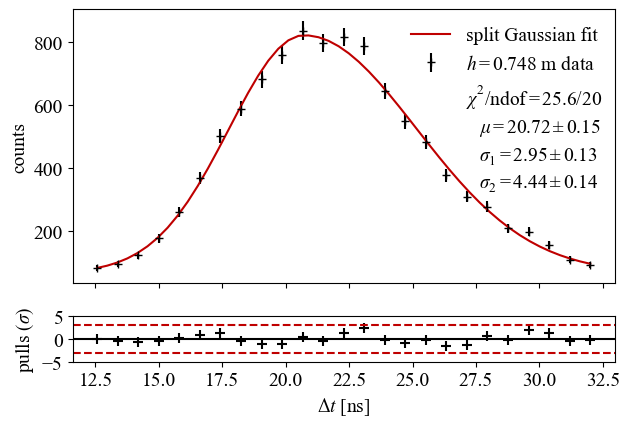

[[ 2.20297349e-02  1.44827131e-02 -1.32490297e-02  1.80076325e-03
  -1.11070160e-01]
 [ 1.44827131e-02  1.59629083e-02 -2.73126349e-03  3.27404648e-04
  -5.99747612e-01]
 [-1.32490297e-02 -2.73126349e-03  1.96355508e-02 -3.37954881e-03
  -6.49193072e-01]
 [ 1.80076325e-03  3.27404648e-04 -3.37954881e-03  5.67695481e-02
  -5.85246783e-01]
 [-1.11070160e-01 -5.99747612e-01 -6.49193072e-01 -5.85246783e-01
   7.30239831e+01]]
 10280 21.906720859999965 0.06258203909518288 0.036820862450359385 0.07261051940937542
20.717664603385977


In [110]:
index = np.arange(10,35, 1)
time, hist, fit_result = run_binned_fit(time0748[index], hist0748[index], np.sqrt(hist0748[index]), split_gaussian_w_bkg, (27.4, 3.2, 4, 20,0,2))
N = np.sum(hist0748[index])
print(time[1]-time[0])
fig, (ax_main, ax_pull) = plot_binned_fit(time, hist, fit_result, r"$\Delta t$ [ns]", "", '')

result = fit_result

const = np.sqrt(2/np.pi)
mu     = result.params['mu'].value
sigma1 = result.params['sigma1'].value
sigma2 = result.params['sigma2'].value

# compute expectation value
ev_dt = mu + const*(sigma2 - sigma1)

# extract covariance matrix and variable order
cov   = result.covar
names = result.var_names

print(cov)
# propagate uncertainty: Var(f) = grad^T * cov * grad
var_ev = (cov[0,0]
          + const**2 * (cov[1,1]+cov[2,2] - 2*cov[1,2]) 
          + 2*const * (cov[0,2] - cov[0,1])
         ) 
stat_err = np.sqrt(var_ev)

# width 
var = (1- 2/np.pi) * (sigma2-sigma1)**2+ sigma1*sigma2

sys_err = np.sqrt(var/N)

print(f'{N: .0f}', ev_dt, stat_err, sys_err, np.sqrt(stat_err**2+sys_err**2))
print(mu)

In [13]:
heights = np.array([0.510, 0.748, 1.013, 1.250, 1.505, 2.010, 2.302, 2.550, 2.862])
Ns = np.array([9573, 10280, 6723, 6266, 5163, 3712, 49227, 38972, 55002])
evdts = np.array([21.71920805, 21.90672256, 22.69635621, 23.19696734, 23.70263816, 25.39171829, 26.29393909, 27.34485319, 28.58409908])
us = np.array([0.07044043, 0.07261029, 0.07490156, 0.10744683, 0.14218658, 0.1358931, 0.05361872, 0.04423014, 0.04493846])

This is the most naive velo analysis

In [84]:
heights = np.array([0.510, 0.748, 1.013, 1.250,1.505, 2.010, 2.302, 2.550, 2.862])

lengths = np.array([0.5573154674678954, 0.7874557414868951, 1.0457472866315753, 1.2775149358869478, 1.528943158261875, 2.028542396708093, 2.318348713000662, 2.5647584386159568, 2.8751763497887737])
lengthserr = np.array([0.043933543345402615, 0.035711504493842736, 0.029095042654040112, 0.02448436019598209, 0.021121290011816257, 0.01627306343148658, 0.014301777743905312, 0.012995717463182982, 0.011467082947727854])


times = evdts
timeserr = np.sqrt(us**2 + 0.3**2)

print(times)
print(timeserr)

[21.71920805 21.90672256 22.69635621 23.19696734 23.70263816 25.39171829
 26.29393909 27.34485319 28.58409908]
[0.30815881 0.30866204 0.30920906 0.31866098 0.33198949 0.32934319
 0.30475395 0.30324298 0.3033471 ]


In [85]:
sigma1 = np.array([2.60281409, 2.95426229, 3.11085182, 3.39731326, 3.59385886, 3.07534511, 3.59210710, 3.51024581, 3.42157369])
sigma1_err = np.array([0.10901783, 0.12634644, 0.12435481, 0.21592249, 0.31833680, 0.24693561, 0.12238098, 0.07665052, 0.08425578])

sigma2 = np.array([4.30318161, 4.44453653, 4.65790314, 4.67361860, 4.87849720, 4.31767959, 5.20942052, 4.88292316, 4.80198088])
sigma2_err = np.array([0.12849649, 0.14012933, 0.12993557, 0.22886569, 0.33288404, 0.27527619, 0.12760114, 0.09958308, 0.10442235])


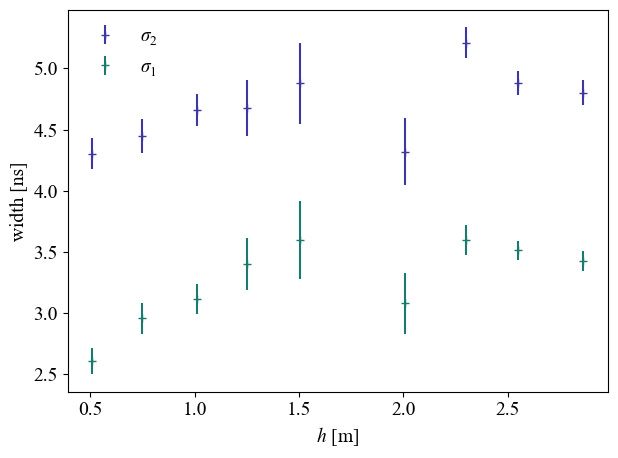

In [86]:
plt.errorbar(heights, sigma2, yerr = sigma2_err, fmt = '+',label = r'$\sigma_2$')
plt.errorbar(heights, sigma1, yerr = sigma1_err, fmt = '+',label = r'$\sigma_1$')
#plt.errorbar(heights, sigma2 - sigma1, yerr = np.sqrt(sigma2_err**2+sigma1_err**2), fmt = '+',label = r'$\sigma_2-\sigma_1$')
plt.xlabel(r'$h$ [m]')
plt.ylabel('width [ns]')
plt.legend(frameon = False, loc = 'upper left')
plt.tight_layout()
plt.savefig('widths.pdf')

Beta: [ 3.00860429 19.53475518]
Beta Std Error: [0.13834855 0.26018331]
Beta Covariance: [[ 0.01893137 -0.03240491]
 [-0.03240491  0.06695633]]
Residual Variance: 1.0110374570493381
Inverse Condition #: 0.021441102427651314
Reason(s) for Halting:
  Sum of squares convergence
[0.13834855 0.26018331]


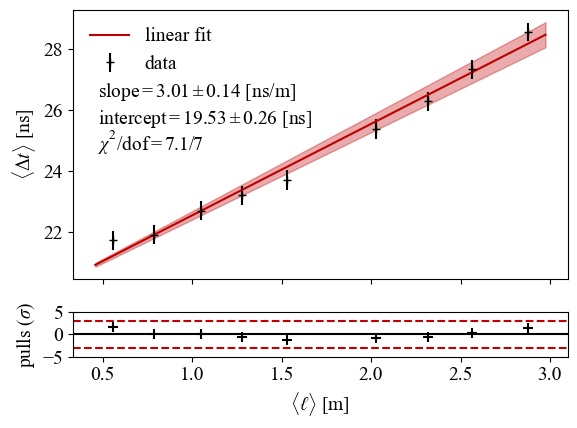

In [87]:
from scipy.odr import ODR, Model, RealData
from scipy.optimize import curve_fit



def f(B, x):
    return B[0] * x + B[1]  # slope * x + intercept


linear = Model(f)
data = RealData(lengths[0:10], times[0:10],  sx = lengthserr[0:10] , sy = timeserr[0:10])

odr = ODR(data, linear, beta0=[1, 0.])
out = odr.run()

out.pprint()

m, b = out.beta
sd_m, sd_b = out.sd_beta

cov_norm = out.cov_beta * out.res_var    

sd_m2, sd_b2 = cov_norm[0,0], cov_norm[1,1]
cov_mb = cov_norm[0,1]

print(np.sqrt(np.diag(cov_norm)))
# Range for plotting fit and bands
y_pred = m * lengths + b

x_fit = np.linspace(min(lengths)-0.1, max(lengths)+0.1, 100)
y_fit = m * x_fit + b

sigma_y = np.sqrt( (x_fit**2)*sd_m2, + sd_b2 + 2*x_fit*cov_mb)

pull = (times - y_pred )/np.sqrt(timeserr**2)


fig, (ax_main, ax_pull) = plt.subplots(
        2, 1, sharex=True,
        gridspec_kw={'height_ratios': [6, 1]},
        figsize=(6, 4.5)
    )
ax_main.errorbar(lengths, times, 
             #xerr = lengthserr,
             yerr = timeserr, fmt='k+', label = 'data')


ax_main.plot(x_fit, y_fit, label = 'linear fit', color = '#BF0000')
ax_main.fill_between(x_fit, y_fit-sigma_y, y_fit+sigma_y, alpha = 0.33, color = '#BF0000')
ax_main.set_ylabel(r'$\langle \Delta t\rangle $ [ns]')
ax_main.legend(frameon = False)
ax_main.annotate(r'slope$=3.01\pm 0.14$ [ns/m]', xy = (0.05,0.65+0.025), xycoords="axes fraction")
ax_main.annotate(r'intercept$=19.53\pm 0.26$ [ns]', xy = (0.05,0.55+0.025), xycoords="axes fraction")
ax_main.annotate(r'$\chi^2/\mathrm{dof} = 7.1/7 $', xy = (0.05,0.45+0.025), xycoords="axes fraction")


ax_pull.scatter(lengths, pull, color='black', marker="+", s=50)
ax_pull.axhline(0, color='black', linestyle='-')
ax_pull.axhline(3, color="#BF0000", linestyle='--')
ax_pull.axhline(-3, color="#BF0000", linestyle='--')
ax_pull.set_ylabel(r"pulls ($\sigma$)")
ax_pull.set_ylim(-5,5)
ax_pull.set_xlabel(r'$\langle\ell\rangle$ [m]')

plt.tight_layout()
plt.savefig('linear_fit.pdf')

In [88]:
vmu = 1/out.beta[0]
sd_vmu = out.sd_beta[0]/out.beta[0]**2
print(vmu)
print(sd_vmu)
print(vmu*1e9/299792458)
print(sd_vmu*1e9/299792458)

0.33238003491482354
0.015284261961196387
1.108700456082933
0.05098281011858006


In [89]:
print(out.sum_square)
print(out.res_var)

7.077262199345367
1.0110374570493381


In [681]:
palette_balanced = [
#    "#7152B8",  # royal purple (new)
    "#3C38A0",  # deep indigo
    "#1B7A6E",  # lighter teal
    "#3A2C20",  # cool dark brown
    "#C26824",  # bright burnt orange
    "#7A014A",  # wine magenta
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette_balanced)

plt.rcParams["font.family"] = "Times New Roman"     # Normal text
plt.rcParams["mathtext.fontset"] = "custom"        # Custom math font
plt.rcParams["mathtext.rm"] = "Times New Roman"    # Roman font for math
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"
plt.rcParams["font.size"] = 14

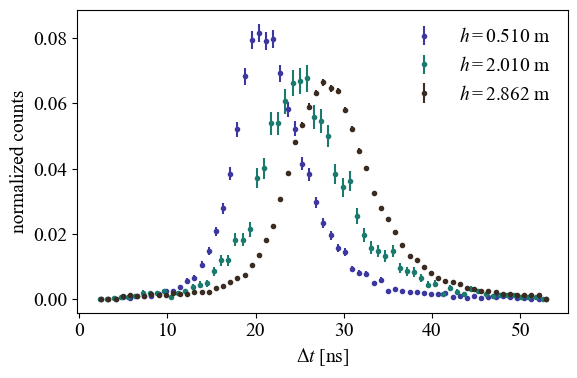

In [682]:
plt.figure(figsize=(3*2, 2*2)) 
hist = read_spe('2025-10-01', '1001-speed-10ft-51.0.Spe')
time, hist = rebin(time_0929, hist, 32)
plt.errorbar( time[1:], hist[1:]/np.sum(hist[1:]), yerr = np.sqrt(hist[1:])/np.sum(hist[1:]), fmt = '.', label = r"$h = 0.510$ m")

hist = read_spe('2025-10-08', '1008-speed-10ft-201.0.Spe')
time, hist = rebin(time_1008, hist, 32)
plt.errorbar( time[1:], hist[1:]/np.sum(hist[1:]), yerr = np.sqrt(hist[1:])/np.sum(hist[1:]), fmt = '.', label = r"$h = 2.010$ m")

hist = read_spe('2025-10-01', '1001-speed-10ft-286.2.Spe')
time, hist = rebin(time_0929, hist, 32)
plt.errorbar( time[1:], hist[1:]/np.sum(hist[1:]), yerr = np.sqrt(hist[1:])/np.sum(hist[1:]), fmt = '.', label = r"$h = 2.862$ m")

plt.xlabel(r'$\Delta t$ [ns]')
plt.ylabel(r'normalized counts')
plt.legend(frameon = False)
plt.tight_layout()
plt.savefig('time_dist.pdf')